In [11]:
import face_recognition
import os
import pandas as pd
import numpy as np
import pickle
from glob import glob
from sklearn.ensemble import RandomForestClassifier
from scikit_checkpoint import ScikitCheckpoint
from sklearn.cluster import KMeans
from PIL import Image
%matplotlib inline
from matplotlib.pyplot import imshow
np.random.seed(4)

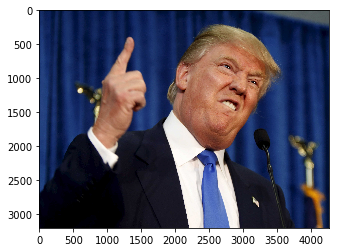

In [12]:
## Load original image

image_path = os.path.join(os.environ.get("DATA_DIR"), 'test','test_image.jpg')

image = face_recognition.load_image_file(image_path)
imgplot = imshow(image)

A face is located at pixel location Top: 430, Left: 2270, Bottom: 1810, Right: 3650


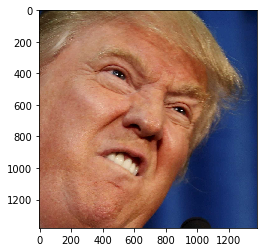

In [13]:
## Facial Detection
face_locations = face_recognition.face_locations(image)
len(face_locations)
for face_location in face_locations:
    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))
    # You can access the actual face itself like this:
    face_image = image[top:bottom, left:right]
    imgplot = imshow(face_image)


In [14]:
data = []
target = []
face_names = []
num_faces = len(face_names)
# Training load data
faces_selected = set()
class_names = ['donald_trump','other']
for file_path in glob(os.environ.get("DATA_DIR")+"/*/*"):
    class_name = file_path.split('/')[-2]
    if class_name in class_names and class_name != 'test':
        if class_name not in faces_selected:
            faces_selected.add(class_name)
            face_names.append(class_name)
        load_image = face_recognition.load_image_file(file_path)
        list_encoding = face_recognition.face_encodings(load_image)
        if len(list_encoding) > 0:
            face_encoding = list_encoding[0]
            data.append(face_encoding)
            target.append(face_names.index(class_name))

In [15]:
print face_names
face_names = np.array(face_names)
data = np.asarray(data)
dimensions = range(len(face_encoding))

['other', 'donald_trump']


In [16]:
df = pd.DataFrame(data, columns=dimensions)
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .60
df['face'] = pd.Categorical.from_codes(target, face_names)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,is_train,face
0,-0.099646,0.150337,-0.031157,-0.067576,-0.099756,0.044092,-0.003369,-0.007982,0.147150,-0.025015,...,0.031742,0.036646,-0.160967,-0.126963,0.033340,0.011252,-0.018887,0.029731,False,other
1,-0.142703,0.055087,0.189977,-0.137793,-0.073138,-0.016489,-0.006097,-0.144066,0.106089,-0.190353,...,-0.082010,0.009533,-0.246792,-0.108270,0.064536,0.018114,-0.005688,0.044132,True,other
2,-0.163849,0.113063,0.044101,-0.036052,-0.040595,-0.009573,-0.040159,-0.059286,0.168056,-0.104745,...,0.006919,0.040857,-0.121037,-0.068038,-0.002045,-0.020345,0.027445,0.019615,False,other
3,-0.105577,0.053696,-0.049880,-0.062775,-0.070559,-0.026069,0.016290,-0.092182,0.175580,-0.096274,...,0.029728,-0.002376,-0.148723,-0.077927,0.028796,0.026030,0.085918,0.002564,False,other
4,-0.143930,0.100308,0.046281,-0.057977,0.023746,-0.086313,0.015235,-0.061996,0.169929,-0.000475,...,0.011518,0.056770,-0.118005,-0.050544,-0.017440,0.057096,0.028643,0.036724,False,other


In [18]:
train, test = df[df['is_train']==True], df[df['is_train']==False]

In [27]:
features = df.columns[:len(face_encoding)]
clf = RandomForestClassifier(n_jobs=8)
y, _ = pd.factorize(train['face'])
clf.fit(train[features], y)
checkpoint = ScikitCheckpoint(os.environ['SNAPSHOTS_DIR'], )
stats = {'label': 'random_forest'}
# save the model to disk
filename = os.path.join(os.environ['SHARED_OUTPUT_DIR'],'finalized_model.pkl')
pickle.dump(clf, open(filename, 'wb'))


In [28]:
checkpoint.save_model(clf, stats)
preds = face_names[np.array(clf.predict(test[features]))]
cross_validation = pd.crosstab(test['face'], preds, rownames=['actual'], colnames=['preds'])
print(cross_validation)

preds         donald_trump  other
actual                           
other                    0      8
donald_trump             5      0


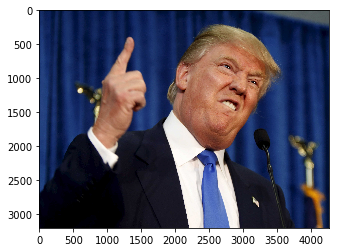

In [29]:
## Load test image

image_path = os.path.join(os.environ.get("DATA_DIR"), 'test','test_image.jpg')
#image_path = os.path.join(os.environ.get("DATA_DIR"), 'test','test_image1.jpg')
load_image = face_recognition.load_image_file(image_path)
imgplot = imshow(load_image)

In [30]:
## Facial Recognition classifier
list_encoding = face_recognition.face_encodings(load_image)
test_pred = face_names[np.array(clf.predict(list_encoding))]
print test_pred

['donald_trump']


In [46]:
import urllib, cStringIO
import scipy 
import pickle
import os
import numpy as np
import face_recognition

filename = os.path.join(os.environ['SHARED_OUTPUT_DIR'],'finalized_model.pkl')
clf = pickle.load( open(filename , "rb" ) )

def recognition(params):
    """
    Loads an image url (.jpg, .png, etc) into a numpy array
    :param url: image url to load
    :return: face recognition over image url
    """
    image_file = cStringIO.StringIO(urllib.urlopen(params['url']).read())
    image = scipy.misc.imread(image_file, mode='RGB')
    # read the image file in a numpy array
    list_encoding = face_recognition.face_encodings(image)
    test_pred = []
    face_names = np.array(['other', 'donald_trump'])
    test_preds = []
    if list_encoding:
        for encoding in list_encoding:
            proba = clf.predict_proba([encoding]).reshape(1, -1)
            proba = proba.reshape(1, -1)
            if proba[0][1] >= 0.7:
                test_pred = face_names[1]
                test_preds.append(test_pred)                
            else:
                test_pred = face_names[0]
                test_preds.append(test_pred)                
    return test_preds

print recognition({'url':'http://images.huffingtonpost.com/2017-02-11-1486846762-7068853-trump.jpg'})
print recognition({'url':'http://cdn.newsday.com/polopoly_fs/1.12048828.1484919016!/httpImage/image.jpg_gen/derivatives/display_1004/image.jpg'})

['donald_trump']
['other', 'other', 'other', 'other']
